In [1]:
import os 
import numpy as np

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import recall_score, f1_score
import re
from sklearn.metrics import confusion_matrix

C:\Users\Kanishk\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_val_data_path = os.path.join("D:/College/ECS/2/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")
train_data_path = os.path.join(train_val_data_path, "train_tomato")
val_data_path = os.path.join(train_val_data_path, "valid_tomato")
test_data_path = os.path.join("D:/College/ECS/2/test/test_tomato")

classes = os.listdir(train_data_path)
classes

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

C:\Users\Kanishk\AppData\Local\Temp\ipykernel_7444\1731212586.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


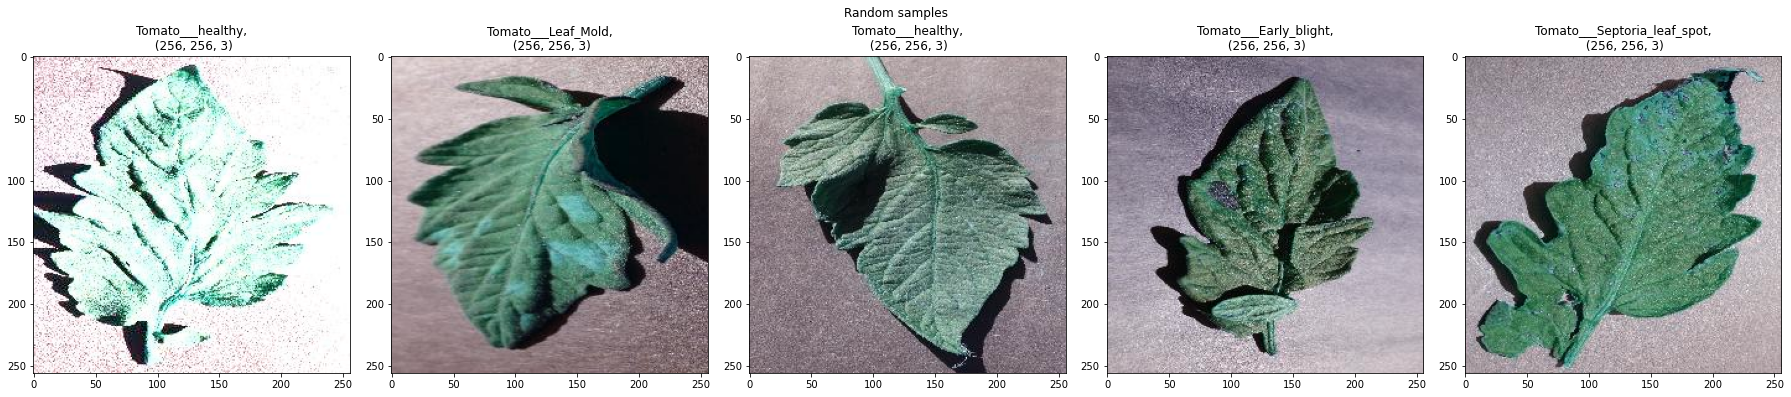

In [4]:
def show_random_sample(data_path, n_samples):
    classes = os.listdir(data_path)
    fig, ax = plt.subplots(1, n_samples, figsize=(5*n_samples, 6))
    fig.figure.figsize=(5*n_samples, 5)
    for i in range(n_samples):
        rand_class = classes[np.random.randint(0, len(classes), 1)[0]]
        rand_class_path = os.path.join(data_path, rand_class)
        samples = os.listdir(rand_class_path)
        rand_sample = np.random.randint(0, len(samples), 1)[0]
        img = cv2.imread(os.path.join(rand_class_path, samples[rand_sample]), cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].set_title(f"{rand_class},\n {img.shape}")
    fig.tight_layout()
    fig.suptitle("Random samples")
    fig.show()
    
show_random_sample(train_data_path, n_samples=5)

In [5]:
img_height, img_width = 256, 256
batch_size = 64

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Flow data from the training directory
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classes,
    class_mode='categorical'  # Set to 'binary' or 'categorical' based on your problem
)

# Create an ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
# Flow data from the validation directory
validation_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classes,
    class_mode='categorical'
)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


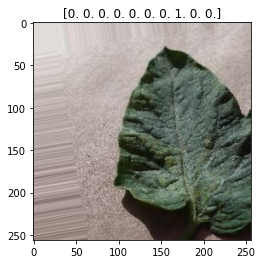

In [6]:
rand_batch = next(iter(train_generator))
plt.imshow(rand_batch[0][0])
plt.title(str(rand_batch[1][1]))
plt.show()

In [7]:
train_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___healthy': 2,
 'Tomato___Late_blight': 3,
 'Tomato___Leaf_Mold': 4,
 'Tomato___Septoria_leaf_spot': 5,
 'Tomato___Spider_mites Two-spotted_spider_mite': 6,
 'Tomato___Target_Spot': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 9}

In [8]:
# Building the model

In [9]:
mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False)

for layer in mobilenet_v2.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 6s 1us/step


In [10]:
# Add custom layers on top of the base model
x = mobilenet_v2.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(len(classes), activation='softmax')(x)  # Output layer

# Create the final model
model = tf.keras.Model(inputs=mobilenet_v2.input, outputs=predictions)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, None, None, 144)      0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, None, None, 144)      0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, None, None, 144)      1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, None, None, 144)      576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, None, None, 192)      768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, None, None, 192)      0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, None, None, 64)       12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, None, None, 64)       256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, None, None, 64)       0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, None, None, 384)      24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, None, None, 384)      1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, None, None, 384)      0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, None, None, 576)      0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, None, None, 576)      0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, None, None, 576)      5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, None, None, 960)      3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, None, None, 960)      0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, None, None, 320)      307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  # Standard metric
                       tf.keras.metrics.Recall()])

In [13]:
results = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12,
    steps_per_epoch=200,
    verbose=1)

Epoch 1/12
200/200 [==============================] - 955s 5s/step - loss: 0.7006 - accuracy: 0.7601 - recall: 0.6857 - val_loss: 0.4691 - val_accuracy: 0.8284 - val_recall: 0.7919
Epoch 2/12
200/200 [==============================] - 600s 3s/step - loss: 0.3899 - accuracy: 0.8646 - recall: 0.8345 - val_loss: 0.3696 - val_accuracy: 0.8774 - val_recall: 0.8517
Epoch 3/12
200/200 [==============================] - 561s 3s/step - loss: 0.3344 - accuracy: 0.8885 - recall: 0.8666 - val_loss: 0.3471 - val_accuracy: 0.8866 - val_recall: 0.8615
Epoch 4/12
200/200 [==============================] - 602s 3s/step - loss: 0.2748 - accuracy: 0.9064 - recall: 0.8899 - val_loss: 0.3351 - val_accuracy: 0.8814 - val_recall: 0.8685
Epoch 5/12
200/200 [==============================] - 633s 3s/step - loss: 0.2781 - accuracy: 0.9033 - recall: 0.8875 - val_loss: 0.3173 - val_accuracy: 0.8896 - val_recall: 0.8715
Epoch 6/12
200/200 [==============================] - 559s 3s/step - loss: 0.2499 - accuracy: 0

In [14]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))